# Generate data and calculate similarity

The goal of this notebook is to determine how much of the structure in the original dataset (single experiment) is retained after adding some number of experiments.

For this simulation experiment we wanted to capture the individual experiment structure.
In particular, we simulated data by (1) preserving the relationship between samples within an experiment but (2) shifting the samples in space.

Criteria (1) will account for the type of experiment, such as treatment vs non-treatment.  Criteria (2) will reflect a different type of perturbation, like a different antibiotic.  

The approach is to,
1. Randomly sample an experiment from the Pseudomonas compendium
2. Embed samples from the experiment into the trained latent space
3. Randomly shift the samples to a new location in the latent space. This new location will be selected based on the distribution of samples in the latent space 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings(action='ignore')

from plotnine import (ggplot, 
                      labs,  
                      geom_line, 
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      element_text,
                      element_rect,
                      element_line)

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'
num_simulated_experiments = 600
lst_num_partitions = [1,2,3,5,10,20,30,50,70,100,200,300,400,500,600]
use_pca = True
num_PCs = 10

In [3]:
# Input files

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../..")) 

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../..")) 

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

In [4]:
# Output file
svcca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_svcca.png")

svcca_blk_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_svcca_blk.png")

similarity_uncorrected_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_similarity_uncorrected.pickle")

permuted_score_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_permuted.txt")

### Load file with experiment ids

In [5]:
experiment_ids_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "experiment_ids.txt")

### Generate simulated data

In [6]:
# Generate simulated data
generate_data.simulate_compendium(experiment_ids_file, 
                                  num_simulated_experiments,
                                  normalized_data_file,
                                  NN_architecture,
                                  analysis_name
                                 )

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/simulated/analysis_1


Normalized gene expression data contains 950 samples and 5549 genes
(5346, 5550)
Return: simulated gene expression data containing 5346 samples and 5550 genes


In [7]:
# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [8]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

simulated_data.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
0,0.649,0.707,0.453,0.678,0.305,0.465,0.375,0.544,0.437,0.403,...,0.497,0.673,0.509,0.645,0.174,0.462,0.229,0.508,0.687,E-MEXP-2606_0
1,0.622,0.690,0.438,0.676,0.323,0.500,0.362,0.551,0.445,0.353,...,0.511,0.640,0.516,0.644,0.188,0.487,0.264,0.524,0.678,E-MEXP-2606_0
2,0.641,0.703,0.451,0.671,0.325,0.458,0.370,0.549,0.449,0.387,...,0.512,0.684,0.523,0.655,0.169,0.453,0.256,0.538,0.695,E-MEXP-2606_0
3,0.573,0.650,0.402,0.692,0.301,0.533,0.369,0.573,0.432,0.299,...,0.534,0.534,0.494,0.622,0.227,0.529,0.303,0.489,0.647,E-MEXP-2606_0
4,0.617,0.676,0.459,0.665,0.334,0.469,0.368,0.545,0.442,0.351,...,0.527,0.679,0.529,0.647,0.186,0.459,0.289,0.553,0.686,E-MEXP-2606_0


In [9]:
ids = set([i.split("_")[0] for i in simulated_data['experiment_id']])
len(ids)     
#simulated_data['experiment_id'].sort_values()

107

In [10]:
normalized_data = pd.read_table(
        normalized_data_file,
        header=0,
        sep='\t',
        index_col=0).T

normalized_data.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


### Generate permuted version of simulated data (negative control)

In [11]:
# Permute simulated data to be used as a negative control
generate_data.permute_data(simulated_data_file,
                          local_dir,
                          analysis_name)

In [12]:
# Permuted simulated data file 
permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [13]:
# Read in data
permuted_data = pd.read_table(
    permuted_simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

permuted_data.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.088,0.450,0.471,0.379,0.336,0.318,0.711,0.119,0.457,0.295,...,0.442,0.452,0.476,0.319,0.465,0.600,0.337,0.377,0.213,0.842
1,0.191,0.427,0.384,0.623,0.422,0.201,0.335,0.734,0.371,0.177,...,0.180,0.306,0.402,0.356,0.676,0.645,0.234,0.241,0.475,0.475
2,0.340,0.399,0.464,0.546,0.326,0.589,0.198,0.341,0.393,0.244,...,0.236,0.491,0.431,0.616,0.657,0.212,0.312,0.491,0.229,0.448
3,0.393,0.592,0.645,0.442,0.576,0.360,0.411,0.476,0.432,0.541,...,0.333,0.254,0.184,0.150,0.590,0.385,0.500,0.489,0.679,0.278
4,0.324,0.310,0.480,0.244,0.328,0.304,0.498,0.346,0.625,0.636,...,0.382,0.294,0.407,0.616,0.794,0.704,0.782,0.306,0.697,0.371


### Partition experiments in simulated data and add technical variation

For this simulation experiment we want to capture the experiment-level information.  In []() we divided our samples into experiments, we divide the experiments (by experiment id) into partitions where each partition is capturing a source of technical variation (i.e. these 3 experiments came from lab A and these other 3 experiments came from lab B and so lab A and B are our partitions).

In [14]:
# Add technical variation to partitions
generate_data.add_experiments_grped(simulated_data_file,
                                    lst_num_partitions,
                                    local_dir,
                                    analysis_name)

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/partition_simulated/analysis_1


Creating simulated data with 1 partitions..
Creating simulated data with 2 partitions..
Creating simulated data with 3 partitions..
Creating simulated data with 5 partitions..
Creating simulated data with 10 partitions..
Creating simulated data with 20 partitions..
Creating simulated data with 30 partitions..
Creating simulated data with 50 partitions..
Creating simulated data with 70 partitions..
Creating simulated data with 100 partitions..
Creating simulated data with 200 partitions..
Creating simulated data with 300 partitions..
Creating simulated data with 400 partitions..
Creating simulated data with 500 partitions..
Creating simulated data with 600 partitions..


### Calculate similarity

In [15]:
# Calculate similarity
similarity_scores, permuted_score = similarity_metric.sim_svcca(simulated_data_file,
                                                           permuted_simulated_data_file,
                                                           'Partition',
                                                           lst_num_partitions,
                                                           use_pca,
                                                           num_PCs,
                                                           local_dir,
                                                           analysis_name)

Calculating SVCCA score for 1 partition vs 1 partitions..
Calculating SVCCA score for 1 partition vs 2 partitions..
Calculating SVCCA score for 1 partition vs 3 partitions..
Calculating SVCCA score for 1 partition vs 5 partitions..
Calculating SVCCA score for 1 partition vs 10 partitions..
Calculating SVCCA score for 1 partition vs 20 partitions..
Calculating SVCCA score for 1 partition vs 30 partitions..
Calculating SVCCA score for 1 partition vs 50 partitions..
Calculating SVCCA score for 1 partition vs 70 partitions..
Calculating SVCCA score for 1 partition vs 100 partitions..
Calculating SVCCA score for 1 partition vs 200 partitions..
Calculating SVCCA score for 1 partition vs 300 partitions..
Calculating SVCCA score for 1 partition vs 400 partitions..
Calculating SVCCA score for 1 partition vs 500 partitions..
Calculating SVCCA score for 1 partition vs 600 partitions..


In [16]:
# Convert similarity scores to pandas dataframe
similarity_score_df = pd.DataFrame(data={'score': similarity_scores},
                                     index=lst_num_partitions,
                                   columns=['score'])
similarity_score_df.index.name = 'number of partitions'
similarity_score_df

,score
number of partitions,
1,0.999994
2,0.903469
3,0.814640
5,0.630955
10,0.249947
20,0.355961
30,0.388235
50,0.482237
70,0.568387


In [17]:
print("Similarity between input vs permuted data is {}".format(permuted_score))

Similarity between input vs permuted data is 0.11971988799624626


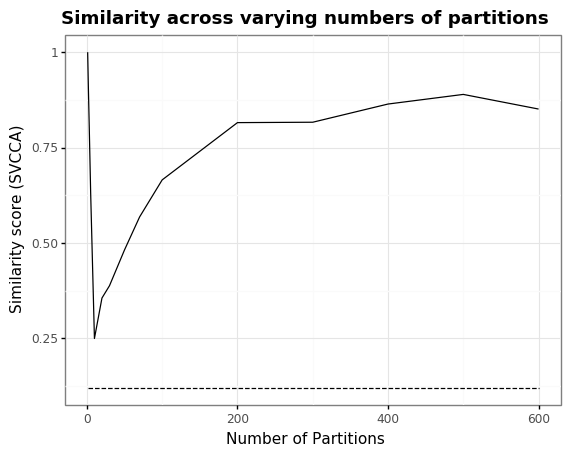

<ggplot: (-9223363259749400639)>


In [18]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_partitions, y='score')) \
    + geom_line() \
    + geom_line(aes(x=lst_num_partitions, y='score'), threshold, linetype='dashed') \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of partitions") \
    + theme_bw() \
    + theme(plot_title=element_text(weight='bold'))

print(g)
ggsave(plot=g, filename=svcca_file, dpi=300)

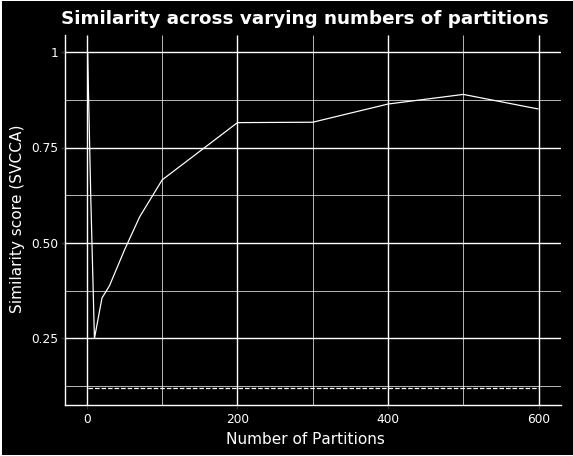

<ggplot: (-9223363259631510654)>


In [22]:
# Plot - black
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_partitions, y='score')) \
    + geom_line(color="white") \
    + geom_line(threshold, aes(x=lst_num_partitions, y='score'), color="white", linetype='dashed') \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of partitions") \
    + theme(plot_title=element_text(weight='bold', colour="white"),
            plot_background=element_rect(fill="black"),
            panel_background=element_rect(fill="black"),
            axis_title_x=element_text(colour="white"),
            axis_title_y=element_text(colour="white"),
            axis_line=element_line(color="white"),
            axis_text=element_text(color="white")
           )


print(g)
ggsave(plot=g, filename=svcca_blk_file, dpi=300)

In [ ]:
# Pickle similarity scores to overlay uncorrected and corrected svcca curves
similarity_score_df.to_pickle(similarity_uncorrected_file)
np.save(permuted_score_file, permuted_score)